**Mount to google drive** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import the essential libraries** 

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import cv2
import glob
import tensorflow as ts
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, Conv3DTranspose
from tensorflow.keras.models import Sequential
import os
import matplotlib.pyplot as plt
import math


import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import random
import shutil
import keras
from keras.models import load_model


import skimage
import scipy

**For the side RGB camera**

1. Preprocessing for normal data

In [ ]:
#Process train frames to npy file

# initialize parameters
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3


path_for_xtrain = glob.glob('/content/drive/MyDrive/thermal_data_1/frames/train/rgb_train_side_camera_frames/*jpg')
X_train = []
for trainingxfile in path_for_xtrain:

    #Read images
    img = cv2.imread(trainingxfile)

    #Resize images 
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 

    #From thermal to gray
    img_gray = 0.2989*img_resized[:,:,0]+0.5870*img_resized[:,:,1]+0.1140*img_resized[:,:,2] #
    
    X_train.append(img_gray)
    
#Store images to npy file
X_train= np.array(X_train)

#Reshape npy file to 5D tensor
X_train = X_train.reshape(-1,IMG_HEIGHT,IMG_WIDTH,10,1)
print('X_train shape:', X_train.shape)
np.save('rgb_train.npy',X_train)

X_train shape: (141, 240, 240, 10, 1)


In [ ]:
#Train data normalization

X_train = np.load('rgb_train.npy')
X_train = X_train.astype('float64') / 255.
np.save('normalised_rgb_train_side_camera.npy', X_train)

2. Building the model

In [ ]:
#Building the model
def load_custom_model():

	model=Sequential()
	model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',input_shape=(240,240,10,1),activation='tanh'))
	model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3D(filters=64,kernel_size=(3,3,1),strides=(2,2,1),padding='same',activation='tanh'))

	model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

	model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))

	model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

	model.add(Conv3DTranspose(filters=64,kernel_size=(3,3,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3DTranspose(filters=1,kernel_size=(1,11,11),strides=(4,4,1),padding='same',activation='tanh'))

	model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy','mean_squared_error'])

	return model

3. Fitting the model

In [ ]:
#Import essential libraries for model fitting
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 

#Load the normalised data to X_train
X_train = np.load('normalised_rgb_train_side_camera.npy')

frames = X_train.shape[2]
print(X_train.shape[2])

#Need to make number of frames divisible by 10
frames = frames-frames%10
X_train = X_train[:,:,:frames]
X_train = X_train.reshape(-1,240,240,10)
X_train = np.expand_dims(X_train,axis=4)

Y_train = X_train.copy()

epochs= 100
batch_size=1

model = load_custom_model()
from contextlib import redirect_stdout

with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
model.summary()
print(model.summary())
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)

model.summary(print_fn=myprint)
print('Model has been loaded')

#Fit the model
earlystopper = keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint('abnormal_model_for_rgb_side_camera.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size= batch_size, epochs= epochs,
                    callbacks=[earlystopper, checkpointer])

#Save the final model, once training is completed
model_name = 'abnormal_model_for_rgb_side_camera.h5'
model.save(model_name)
model.save('content/drive/MyDrive/thermal_data_1/side_camera_h5')

240
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 60, 60, 10, 128)   15616     
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 30, 10, 64)    204864    
                                                                 
 conv3d_2 (Conv3D)           (None, 15, 15, 10, 64)    36928     
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 15, 15, 10, 64)    295168    
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 15, 15, 10, 32)    110720    
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 15, 15, 10, 64)    221440    
                                                                 
 conv3d_transpose (Conv3DTra  (None, 30, 30, 10, 64)

4. Predictions on train set to compute the normal losses

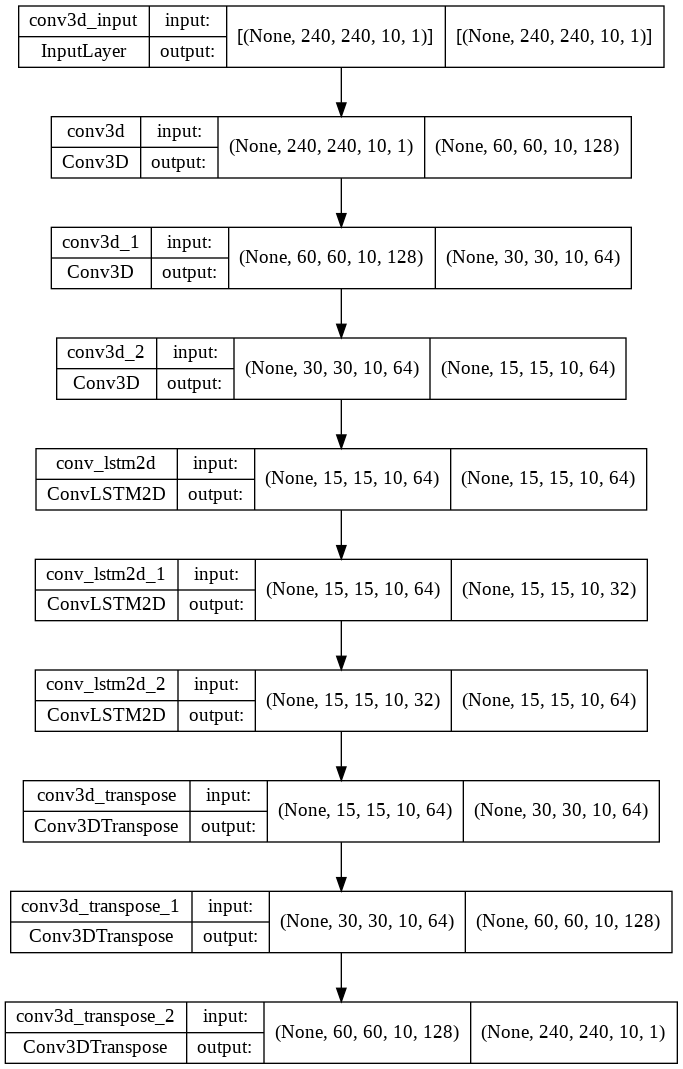

In [ ]:
dot_img_file = 'model_2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='TB')

In [ ]:
#Load the model and normalised train data
X_train=np.load('/content/normalised_rgb_train_side_camera.npy')
model = load_model('/content/abnormal_model_for_rgb_side_camera.h5')
print(X_train.shape)

#Compute losses for normal data

normal_losses_for_rgb_side_camera = []

for x in X_train:
    x = np.expand_dims(x, axis=0)
    reconstructions = model.predict(x)
    train_loss = tf.keras.losses.mse(reconstructions, x)   
    print(train_loss)
    normal_losses_for_rgb_side_camera.append(np.mean(train_loss))
    print("Normal losses for RGB side camera: ", normal_losses_for_rgb_side_camera)

#Total loss for train data
loss_total_train=np.mean(train_loss)
threshold = np.std(train_loss)
print("threshold: ", threshold)
print("Total loss for train data for RGB side camera is: ",loss_total_train)


Streaming output truncated to the last 5000 lines.
    1.10034325e-03 1.68212975e-03]
   [3.05785248e-04 4.47362298e-03 2.23532893e-03 ... 1.33208953e-04
    1.76075339e-02 2.02750938e-02]
   ...
   [1.14522822e-01 4.48626121e-03 2.95018838e-03 ... 1.01413208e-03
    1.58787288e-01 1.15321801e-01]
   [1.52725905e-01 2.05233206e-01 1.36394692e-01 ... 5.78429602e-03
    9.96216344e-03 9.72954994e-03]
   [1.07026836e-02 9.98746484e-03 1.07865841e-02 ... 1.40776016e-02
    1.19219103e-02 9.41273785e-03]]

  [[3.92421800e-03 7.42537884e-03 6.69163307e-03 ... 7.39627835e-03
    5.82235587e-03 9.59939852e-03]
   [5.54272231e-03 7.08066987e-03 1.33439759e-02 ... 7.96378646e-03
    7.43267979e-03 1.20428785e-02]
   [2.85055057e-02 1.29188743e-02 1.08575686e-02 ... 7.35579510e-03
    6.77194271e-03 5.89078081e-03]
   ...
   [1.53274131e-01 1.46509759e-01 1.93116863e-01 ... 1.22792562e-01
    1.33907241e-01 1.44252248e-01]
   [1.16308850e-01 1.19733403e-01 1.01491249e-01 ... 2.00877309e-01
    1.

In [ ]:
#Setting the labels for y_train as 0
y_train_rgb_side_camera = []
for i in range(len(normal_losses_for_rgb_side_camera)):
  y_train_rgb_side_camera.append(0)

print(y_train_rgb_side_camera)
print(len(y_train_rgb_side_camera))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
141


5. Preprocessing for test data with falling action

In [ ]:
#Process test frames to npy file

# initialize parameters
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3


path_for_xtest = glob.glob('/content/drive/MyDrive/thermal_data_1/frames/test/rgb_test_side_camera_frames/*jpg')
X_test = []
for testingxfile in path_for_xtest:

    #Read images
    img = cv2.imread(testingxfile)

    #Resize images 
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 

    #From thermal to gray
    img_gray = 0.2989*img_resized[:,:,0]+0.5870*img_resized[:,:,1]+0.1140*img_resized[:,:,2] 
    
    X_test.append(img_gray)
    
#Store images to npy file
X_test= np.array(X_test)

#Reshape npy file to 5D tensor
X_test = X_test.reshape(-1,IMG_HEIGHT,IMG_WIDTH,10,1)
print('X_test shape:', X_test.shape)
np.save('rgb_test_side_camera.npy',X_test)

X_test shape: (141, 240, 240, 10, 1)


In [ ]:
#Test data normalization

X_test = np.load('rgb_test_side_camera.npy')
X_test = X_test.astype('float64') / 255.
np.save('normalised_rgb_test_side_camera.npy', X_test)

6. Testing the model

In [ ]:
#Load the model and normalised test data
X_test=np.load('normalised_rgb_test_side_camera.npy')   
model = load_model('/content/abnormal_model_for_rgb_side_camera.h5')
print(X_test.shape)

#Compute losses for abnormal data
losses_for_rgb_side_camera = []

for x in X_test:
    x = np.expand_dims(x, axis=0)
    reconstructions = model.predict(x)
    test_loss = tf.keras.losses.mse(reconstructions, x)
    print(test_loss)
    losses_for_rgb_side_camera.append(np.mean(test_loss))
    print("Abnormal losses for the rgb side camera data: ", losses_for_rgb_side_camera)

#Total loss for test data
loss_total_test=np.mean(test_loss)
print("Total loss for test data is: ",loss_total_test)

Streaming output truncated to the last 5000 lines.
   [6.84907956e-03 7.41428196e-03 5.85308131e-02 ... 3.02618260e-02
    1.67750677e-01 1.37548812e-01]
   [1.26250944e-01 1.60022315e-01 1.92005175e-02 ... 1.84143344e-01
    1.74397662e-01 1.69800918e-01]
   ...
   [1.74432710e-01 1.69467225e-01 1.92464271e-01 ... 1.67978188e-01
    1.67978188e-01 1.67978188e-01]
   [1.67978188e-01 1.74468090e-01 1.77759167e-01 ... 1.76665648e-01
    1.86692830e-01 1.79977291e-01]
   [1.83319685e-01 1.92035093e-01 1.95487130e-01 ... 2.01066825e-01
    1.97565652e-01 2.08161424e-01]]

  [[3.46771766e-02 1.68033161e-01 1.50486529e-01 ... 9.30664192e-02
    7.60228433e-02 1.54982129e-01]
   [1.93361309e-01 1.71773557e-01 1.59018334e-01 ... 7.98548090e-02
    1.10029085e-01 7.72739981e-02]
   [7.08722796e-02 1.08690487e-01 1.14973418e-01 ... 8.82926752e-02
    1.21496295e-01 9.32876350e-02]
   ...
   [1.71668253e-01 1.29191511e-01 2.08200073e-01 ... 1.92035093e-01
    1.92035093e-01 1.92035093e-01]
   [1.

In [ ]:
#Setting the labels for y_test as 1

y_test_rgb_side_camera=[]
for i in range(len(losses_for_rgb_side_camera)):
  y_test_rgb_side_camera.append(1)

print(y_test_rgb_side_camera)
print(len(y_test_rgb_side_camera))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
141


6. Creating y_test list from joining the lists y_train and y_test

In [ ]:
for x in y_train_rgb_side_camera:
  y_test_rgb_side_camera.append(x)

print(y_test_rgb_side_camera)
print(len(y_test_rgb_side_camera))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
282


7. Creating losses from joining the lists of normal and abnormal losses

In [ ]:
for x in normal_losses_for_rgb_side_camera:
  losses_for_rgb_side_camera.append(x) 

print(losses_for_rgb_side_camera)
print(len(losses_for_rgb_side_camera))

[0.06826409796490142, 0.0681115987252988, 0.06808477792234045, 0.06748953614581196, 0.0675642244372015, 0.06782049897386441, 0.06729365155492142, 0.06549739245527098, 0.06576979680401832, 0.0655436537979392, 0.0653559693110913, 0.06524760866674878, 0.0652566364444654, 0.06522737382607707, 0.06521662481977977, 0.09685246532282485, 0.09693903332740927, 0.09715008876722538, 0.09700417364275495, 0.09692067321046953, 0.09690226572589482, 0.09732266096193092, 0.09737290275364878, 0.09365925219087777, 0.09677683790992345, 0.0870556566423972, 0.0859315952813286, 0.08581211350648166, 0.08581364358500773, 0.0860699005322734, 0.08587445854130463, 0.08642423189925233, 0.08661440016450082, 0.0793051194458512, 0.07937133300336867, 0.07578074179974643, 0.07585712023123674, 0.07529933502608423, 0.0752709191025489, 0.07577419148285197, 0.07580649006561406, 0.07615606512212131, 0.07644264224895882, 0.07468565419328252, 0.0744657690897406, 0.07458815662684297, 0.07430103902769394, 0.0744271898467574, 0.0

8. Plotting the ROC curve

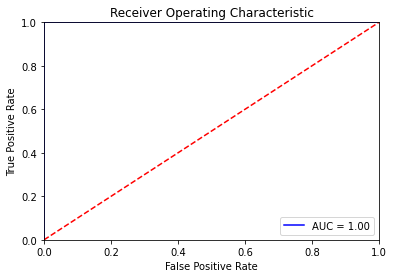

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test_rgb_side_camera,losses_for_rgb_side_camera)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

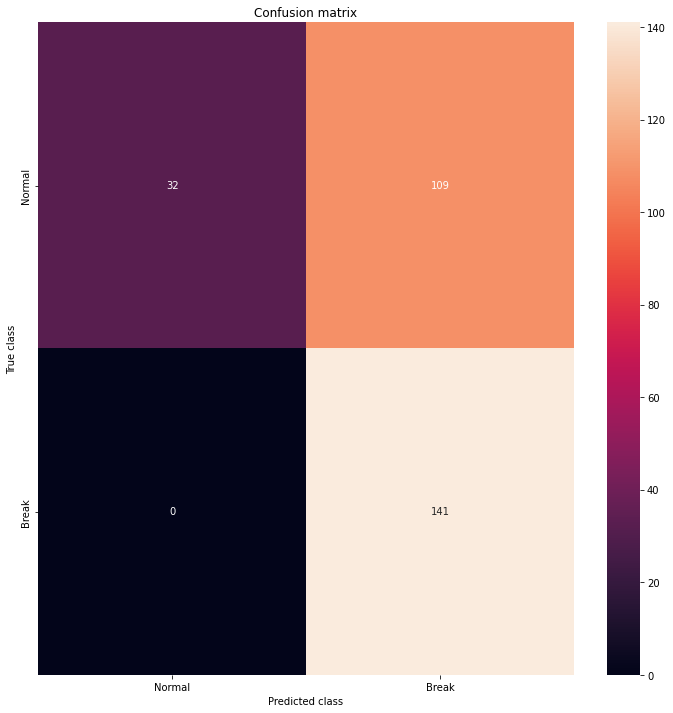

In [ ]:
pred_y_rgb_side_camera = [1 if e > 0.0584836872662998 else 0 for e in losses_for_rgb_side_camera]
conf_matrix = confusion_matrix(y_test_rgb_side_camera, pred_y_rgb_side_camera)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
   
   
if conf_matrix.shape == (2,2):

    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[1][1]

    accuracyscore = accuracy_score(y_test_rgb_side_camera, pred_y_rgb_side_camera)
    precisionscore = precision_score(y_test_rgb_side_camera, pred_y_rgb_side_camera, average='macro',zero_division='warn')
    recallscore = recall_score(y_test_rgb_side_camera, pred_y_rgb_side_camera, average='macro',zero_division='warn')
    f1 = f1_score(y_test_rgb_side_camera, pred_y_rgb_side_camera, average='macro',zero_division='warn')
    print('scores ; ',accuracyscore, ';', precisionscore, ';', recallscore, ';', f1)

scores ;  0.6134751773049646 ; 0.782 ; 0.6134751773049645 ; 0.5455849090075839


**For the above RGB camera**

In [ ]:
#Process train frames to npy file

# initialize parameters
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3


path_for_xtrain = glob.glob('/content/drive/MyDrive/thermal_data_1/frames/train/rgb_train_above_camera_frames/*jpg')
X_train = []
for trainingxfile in path_for_xtrain:

    #Read images
    img = cv2.imread(trainingxfile)

    #Resize images 
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 

    #From thermal to gray
    img_gray = 0.2989*img_resized[:,:,0]+0.5870*img_resized[:,:,1]+0.1140*img_resized[:,:,2] #
    
    X_train.append(img_gray)
    
#Store images to npy file
X_train= np.array(X_train)

#Reshape npy file to 5D tensor
X_train = X_train.reshape(-1,IMG_HEIGHT,IMG_WIDTH,10,1)
print('X_train shape:', X_train.shape)
np.save('rgb_train_above.npy',X_train)

X_train shape: (96, 240, 240, 10, 1)


In [ ]:
#Train data normalization

X_train = np.load('rgb_train_above.npy')
X_train = X_train.astype('float64') / 255.
np.save('normalised_rgb_train_above.npy', X_train)

In [ ]:
#Building the model
def load_custom_model():

	model=Sequential()
	model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',input_shape=(240,240,10,1),activation='tanh'))
	model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3D(filters=64,kernel_size=(3,3,1),strides=(2,2,1),padding='same',activation='tanh'))

	model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

	model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))

	model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

	model.add(Conv3DTranspose(filters=64,kernel_size=(3,3,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))
	model.add(Conv3DTranspose(filters=1,kernel_size=(1,11,11),strides=(4,4,1),padding='same',activation='tanh'))

	model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy','mean_squared_error'])

	return model

In [ ]:
#Import essential libraries for model fitting
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 

#Load the normalised data to X_train
X_train = np.load('normalised_rgb_train_above.npy')

frames = X_train.shape[2]
print(X_train.shape[2])

#Need to make number of frames divisible by 10
frames = frames-frames%10
X_train = X_train[:,:,:frames]
X_train = X_train.reshape(-1,240,240,10)
X_train = np.expand_dims(X_train,axis=4)

Y_train = X_train.copy()

epochs= 100
batch_size=1

model = load_custom_model()
from contextlib import redirect_stdout

with open('model_summary_45_camera.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
model.summary()
print('Model has been loaded')
print(model.summary())


#Fit the model
earlystopper = keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint('abnormal_model_for_rgb_above_camera.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size= batch_size, epochs= epochs,
                    callbacks=[earlystopper, checkpointer])

#Save the final model, once training is completed
model_name = 'abnormal_model_for_rgb_above_camera.h5'
model.save(model_name)
model.save('path/to/content/drive/MyDrive/thermal_data_1/camera_45_h5')

240
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 60, 60, 10, 128)   15616     
                                                                 
 conv3d_4 (Conv3D)           (None, 30, 30, 10, 64)    204864    
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 15, 10, 64)    36928     
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 15, 15, 10, 64)    295168    
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 15, 15, 10, 32)    110720    
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 15, 15, 10, 64)    221440    
                                                                 
 conv3d_transpose_3 (Conv3DT  (None, 30, 30, 10, 6

In [ ]:
#Import essential libraries for model fitting
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 

#Load the normalised data to X_train
X_train = np.load('normalised_rgb_train_side_camera.npy')

frames = X_train.shape[2]
print(X_train.shape[2])

#Need to make number of frames divisible by 10
frames = frames-frames%10
X_train = X_train[:,:,:frames]
X_train = X_train.reshape(-1,240,240,10)
X_train = np.expand_dims(X_train,axis=4)

Y_train = X_train.copy()

epochs= 100
batch_size=1

model = load_custom_model()
model.summary()
print(model.summary())
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)

model.summary(print_fn=myprint)
print('Model has been loaded')

#Fit the model
earlystopper = keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint('abnormal_model_for_rgb_side_camera.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size= batch_size, epochs= epochs,
                    callbacks=[earlystopper, checkpointer])

#Save the final model, once training is completed
model_name = 'abnormal_model_for_rgb_side_camera.h5'
model.save(model_name)
model.save('content/drive/MyDrive/thermal_data_1/side_camera_h5')

240
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 60, 60, 10, 128)   15616     
                                                                 
 conv3d_7 (Conv3D)           (None, 30, 30, 10, 64)    204864    
                                                                 
 conv3d_8 (Conv3D)           (None, 15, 15, 10, 64)    36928     
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 15, 15, 10, 64)    295168    
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 15, 15, 10, 32)    110720    
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 15, 15, 10, 64)    221440    
                                                                 
 conv3d_transpose_6 (Conv3DT  (None, 30, 30, 10, 6

In [ ]:
#Load the model and normalised train data
X_train=np.load('/content/normalised_rgb_train_above.npy')
model = load_model('/content/abnormal_model_for_rgb_above_camera.h5')
print(X_train.shape)

#Compute losses for normal data

normal_losses_rgb_above_camera = []

for x in X_train:
    x = np.expand_dims(x, axis=0)
    reconstructions = model.predict(x)
    train_loss = tf.keras.losses.mse(reconstructions, x)   
    print(train_loss)
    normal_losses_rgb_above_camera.append(np.mean(train_loss))
    print("Normal losses for the above RGB camera: ", normal_losses_rgb_above_camera)

#Total loss for train data
loss_total_train=np.mean(train_loss)
threshold = np.std(train_loss)
print("threshold: ", threshold)
print("Total loss for train data for the above RGB camera is: ",loss_total_train)


Streaming output truncated to the last 5000 lines.
    8.35992262e-03 5.50134374e-03]
   [6.91983633e-03 8.29379217e-03 9.02337291e-03 ... 6.10501153e-03
    6.17507290e-03 3.11914608e-02]
   ...
   [5.99252810e-02 1.61405060e-01 1.55551001e-01 ... 3.21211913e-02
    3.99331790e-02 6.72411348e-02]
   [1.64482679e-01 1.71595700e-01 9.13688926e-02 ... 6.68907626e-02
    3.92454494e-02 8.38279248e-02]
   [1.21405470e-01 1.24451470e-01 2.20532572e-01 ... 3.29758308e-02
    1.75861770e-01 1.76881875e-01]]

  [[2.83179158e-02 1.28556613e-02 1.19818489e-02 ... 1.12423328e-02
    1.04261848e-02 5.00404561e-03]
   [6.80671341e-03 1.11477295e-02 7.06939112e-03 ... 1.11477295e-02
    1.24008017e-02 1.24008017e-02]
   [1.11477295e-02 1.30548067e-03 1.13875817e-02 ... 1.11387878e-02
    1.49131183e-02 7.33704182e-03]
   ...
   [1.08716012e-01 1.41059405e-01 5.39669045e-02 ... 1.39227559e-01
    2.24835134e-02 6.21915263e-02]
   [8.21570578e-02 1.68656402e-02 1.89557055e-01 ... 1.27069837e-01
    1.

In [ ]:
#Setting the labels for y_train as 0
y_train_rgb_above = []
for i in range(len(normal_losses_rgb_above_camera)):
  y_train_rgb_above.append(0)

print(y_train_rgb_above )
print(len(y_train_rgb_above))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
96


In [ ]:
#Process test frames to npy file

# initialize parameters
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3


path_for_xtest = glob.glob('/content/drive/MyDrive/thermal_data_1/frames/test/rgb_test_above_camera_frames/*jpg')
X_test = []
for testingxfile in path_for_xtest:

    #Read images
    img = cv2.imread(testingxfile)

    #Resize images 
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 

    #From thermal to gray
    img_gray = 0.2989*img_resized[:,:,0]+0.5870*img_resized[:,:,1]+0.1140*img_resized[:,:,2] 
    
    X_test.append(img_gray)
    
#Store images to npy file
X_test= np.array(X_test)

#Reshape npy file to 5D tensor
X_test = X_test.reshape(-1,IMG_HEIGHT,IMG_WIDTH,10,1)
print('X_test shape:', X_test.shape)
np.save('rgb_test_above.npy',X_test)

X_test shape: (96, 240, 240, 10, 1)


In [ ]:
#Test data normalization

X_test = np.load('rgb_test_above.npy')
X_test = X_test.astype('float64') / 255.
np.save('normalised_rgb_test_above.npy', X_test)

In [ ]:
#Load the model and normalised test data
X_test=np.load('/content/normalised_rgb_test_above.npy')   
model = load_model('/content/abnormal_model_for_rgb_above_camera.h5')
print(X_test.shape)

#Compute losses for abnormal data
losses_for_rgb_above_camera = []

for x in X_test:
    x = np.expand_dims(x, axis=0)
    reconstructions = model.predict(x)
    test_loss = tf.keras.losses.mse(reconstructions, x)
    print(test_loss)
    losses_for_rgb_above_camera.append(np.mean(test_loss))
    print("Abnormal losses for the above RGB camera: ", losses_for_rgb_above_camera)

#Total loss for test data
loss_total_test=np.mean(test_loss)
print("Total loss for test data for the above RGB camera is: ",loss_total_test)

Streaming output truncated to the last 5000 lines.
   [9.54491926e-03 7.59496267e-03 1.31325454e-02 ... 5.68298170e-03
    1.03264779e-02 6.72619725e-03]
   [5.50134374e-03 8.07405575e-03 8.79411188e-03 ... 8.79411188e-03
    6.09839487e-03 2.83179158e-02]
   ...
   [5.22681513e-02 1.76287306e-01 1.52374145e-01 ... 4.36701553e-02
    6.26594817e-02 9.48680676e-02]
   [1.65818495e-01 1.84379254e-01 1.36285429e-01 ... 5.80325905e-02
    5.54934722e-02 8.09286112e-02]
   [1.47735575e-01 1.50929458e-01 1.93831919e-01 ... 4.40904209e-02
    1.88391007e-01 1.84929962e-01]]

  [[2.32851038e-02 1.56722083e-02 1.22492084e-02 ... 1.03264779e-02
    1.11387878e-02 6.72619725e-03]
   [6.72619725e-03 5.50134374e-03 6.72619725e-03 ... 9.54491926e-03
    1.46955398e-02 9.54491926e-03]
   [1.28556613e-02 3.89469785e-03 1.11387878e-02 ... 1.24384739e-02
    1.71960706e-02 6.42538429e-03]
   ...
   [1.37815305e-01 1.57438986e-01 6.33327237e-02 ... 1.16888327e-01
    2.76880253e-02 6.18725315e-02]
   [9.

In [ ]:
#Setting the labels for y_test as 1

y_test_above_rgb=[]
for i in range(len(losses_for_rgb_above_camera)):
  y_test_above_rgb.append(1)

print(y_test_above_rgb)
print(len(y_test_above_rgb))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
96


In [ ]:
for x in y_train_rgb_above:
  y_test_above_rgb.append(x)

print(y_test_above_rgb)
print(len(y_test_above_rgb))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
192


In [ ]:
for x in normal_losses_rgb_above_camera:
  losses_for_rgb_above_camera.append(x) 

print(losses_for_rgb_above_camera)
print(len(losses_for_rgb_above_camera))

[0.04620848037388313, 0.045964866811187804, 0.04584430545431999, 0.04581389363748071, 0.046034454409825315, 0.045919279105322286, 0.04583267437927091, 0.04573044390639132, 0.04533549388482232, 0.045195898772094525, 0.045422609624984935, 0.04526057338101988, 0.04502933951863726, 0.04504134822060724, 0.04513793016521966, 0.04514998964422727, 0.04521679014012946, 0.045184790308234, 0.045121518603520865, 0.04510825121427218, 0.04511242228952716, 0.045083727579609705, 0.04508712133869262, 0.04503816403153983, 0.04499610582340788, 0.044961957380024904, 0.04497855989138079, 0.04502522256402904, 0.04501328720522622, 0.045024726542591806, 0.04496562663069539, 0.044933678788055036, 0.0449137942454286, 0.04492710285729001, 0.044923654704635094, 0.04494617163983647, 0.04492518287150327, 0.04488111154678876, 0.04487215853361713, 0.04490907094939668, 0.044879587099359276, 0.04488520153024331, 0.04484850427957598, 0.0448618353056563, 0.04487392168928336, 0.044871960918047224, 0.04472858856481649, 0.0

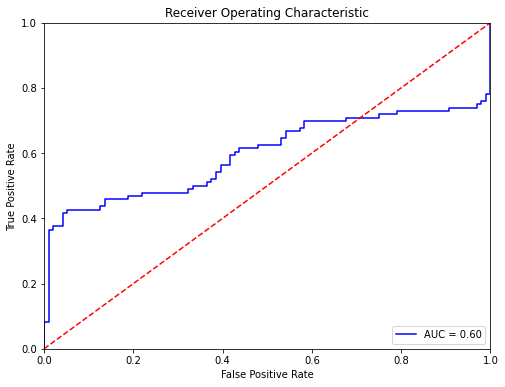

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test_above_rgb,losses_for_rgb_above_camera)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


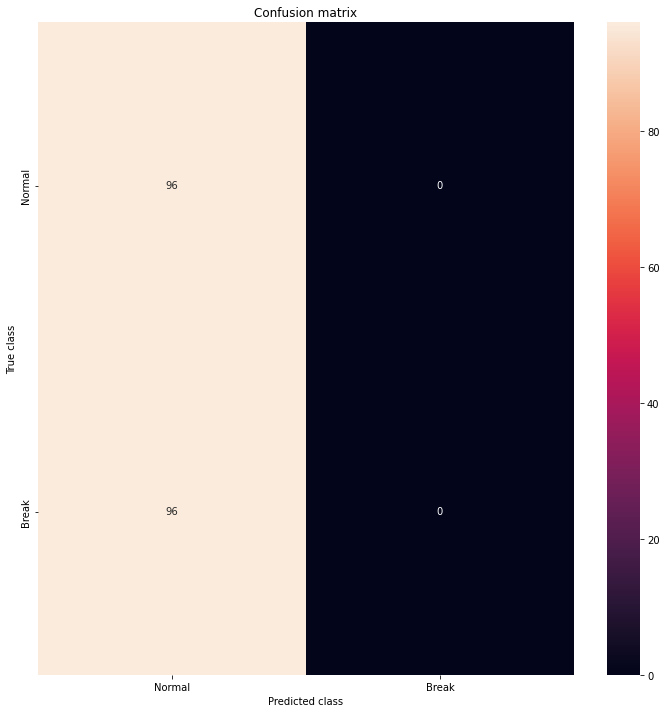

In [ ]:
pred_y_rgb_above_camera = [1 if e > 0.053107138129254834 else 0 for e in losses_for_rgb_above_camera] #e=total_loss
conf_matrix = confusion_matrix(y_test_above_rgb, pred_y_rgb_above_camera)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
   
   
if conf_matrix.shape == (2,2):

    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[1][1]

    accuracyscore = accuracy_score(y_test_above_rgb, pred_y_rgb_above_camera)
    precisionscore = precision_score(y_test_above_rgb, pred_y_rgb_above_camera, average='macro',zero_division='warn')
    recallscore = recall_score(y_test_above_rgb, pred_y_rgb_above_camera , average='macro',zero_division='warn')
    f1 = f1_score(y_test_above_rgb, pred_y_rgb_above_camera , average='macro',zero_division='warn')
    print('scores ; ',accuracyscore, ';', precisionscore, ';', recallscore, ';', f1)

scores ;  0.5 ; 0.25 ; 0.5 ; 0.3333333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
